In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from salishsea_tools import gsw_calls
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized

import warnings
warnings.filterwarnings("ignore")


# Load files

In [2]:
# bathymetry input into model and grid used for coordinates input (x, y)

bathy_file = nc.Dataset('../../bathymetry/NEMO_files/idealized/ideal_bathy_quad.nc')
bathy = bathy_file['Bathymetry']

grid_g = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/grid_quad.nc')
lon_g_grid = grid_g['grid_lons'][:-3,:-3]
lat_g_grid = grid_g['grid_lats'][:-3,:-3]

bathy.shape, lat_g_grid.shape

((360, 480), (480, 360))

In [3]:
# salinity and temperature input into model as initial conditions (x, y, z)

in_s = nc.Dataset('../NEMO_files/salinity/salinity_quad_80.nc')
in_t = nc.Dataset('../NEMO_files/temperature/temperature_quad_80.nc')
sal = in_s['vosaline'][0,:,:,:]
tem = in_t['votemper'][0,:,:,:]

sal.shape

(80, 360, 480)

In [4]:
# mesh mask returned before simulation is run (x, y, z)

mesh_mask = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_quad_480x360/test_80levels/mesh_mask.nc')
deptht = mesh_mask['gdept_1d'][:] # previously used gridT['deptht'] and made a tiny difference in final vels
nav_lon = mesh_mask['nav_lon']
nav_lat = mesh_mask['nav_lat']

deptht.shape, nav_lat.shape

((1, 80), (360, 480))

In [5]:
# wind stress returned after simulation is run so can use existing output (t)

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/eventB_pulse10'

gridU = xr.open_dataset(path + '/GYRE_1h_00010101_00010120_grid_U.nc')
utau = gridU['sozotaux'].values[:,-1,-1]

gridV = xr.open_dataset(path + '/GYRE_1h_00010101_00010120_grid_V.nc')
vtau = gridV['sometauy'].values[:,-1,-1]

vtau.shape

(480,)

In [6]:
# veddyvisc returned after simulation is run so can use existing output (x, z, t)

#gridW = xr.open_dataset(path + '/GYRE_1h_00010101_00010120_grid_W.nc')
#vE = gridW['veddyvisc'][:,:20,:,:].values

# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------

# use the parameter in the namelist as the veddyvisc if the model has not been run before

#rn_avm0 = 1.2e-4
#vE = np.ones([utau.shape[0], deptht.shape[1], utau.shape[1], utau.shape[2]]) * rn_avm0

#vE.shape


# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------

# use only a single number if making this many ones gives memory error
rn_avm0 = 1.2e-4
vE = rn_avm0

# Wind stress and eddy viscosity

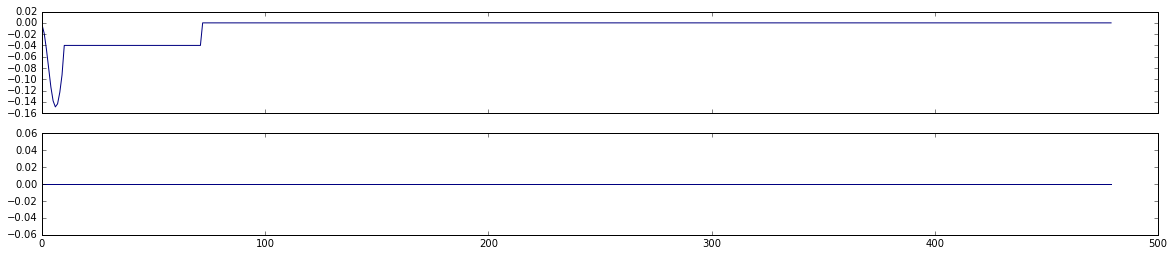

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,4), sharex=True)
ax1.plot(utau[:], c='navy')
ax2.plot(vtau[:], c='navy')

# Coriolis parameter

$$f(\lambda)= 2 \Omega \sin(\lambda)$$

$$\Omega = \frac{2 \pi}{24 hours}$$

The average latitude at the northern boundary is 70.943. The average coriolis parameter is 0.0001374. fpar was calculated at all points along the boundary.

In [8]:
def calculate_coriolis(nav_lat, indN = -2):
    latN = nav_lat[indN,:]
    omega = (2 * np.pi) / (24 * 60 * 60)
    f = 2 * omega * np.sin(np.deg2rad(latN))
    return latN, f

In [9]:
latN, f = calculate_coriolis(nav_lat)
type(latN), type(f), latN.shape, f.shape

(numpy.ndarray, numpy.ndarray, (480,), (480,))

# Ekman layer thickness

$$\delta = \sqrt \frac{2\nu_E}{f}$$

In [10]:
def calculate_ekman_thickness(indt, vE, f, indN = -2):
    # single veddyvisc
    vEN = vE
    fN = np.mean(f)
    delta = np.sqrt((2 * vEN) / fN)
    return vEN, fN, delta

In [11]:
indt = 6
vEN, fN, delta = calculate_ekman_thickness(indt, vE, f, indN = -2)
print(type(vEN), type(fN), type(delta), vEN, fN, delta)

<class 'float'> <class 'numpy.float32'> <class 'numpy.float64'> 0.00012 0.00013859 1.31595122859


# Density

In [12]:
def calculate_pressure(deptht, latN):
    deps = np.transpose(np.tile(-1 * deptht, (latN.shape[0], 1)))
    lats = np.tile(latN, (deps.shape[0], 1))
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [deps,lats], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    return deps, lats, p

In [13]:
deps, lats, p = calculate_pressure(deptht, latN)
type(deps), type(lats), type(p), deps.shape, lats.shape, p.shape 

(numpy.ndarray, numpy.ndarray, numpy.ndarray, (80, 480), (80, 480), (80, 480))

In [14]:
def calculate_rho(sal, tem, p, indN = -2):
    SA = sal[:, indN, :]
    CT = tem[:, indN, :]
    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    return SA, CT, rho

In [15]:
SA, CT, rho = calculate_rho(sal, tem, p)
type(SA), type(rho), SA.shape, rho.shape
# (numpy.ndarray, numpy.ndarray, (80, 237), (80, 237))

(numpy.ndarray, numpy.ndarray, (80, 480), (80, 480))

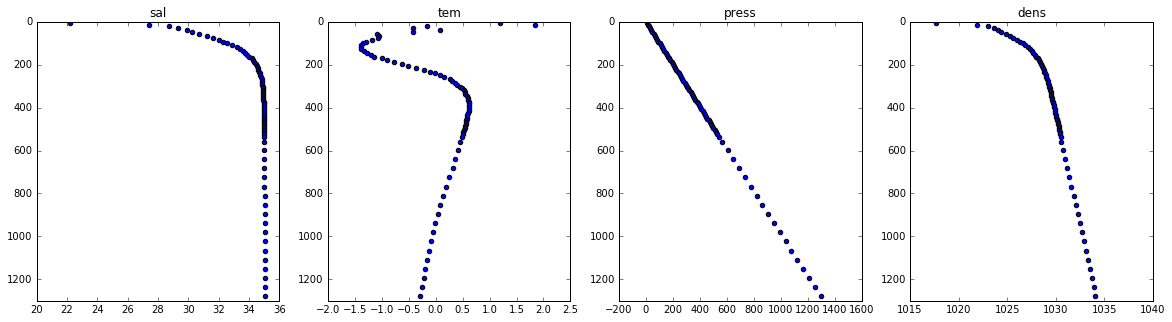

In [16]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
for var, i, ttl in zip([SA, CT, p, rho], np.arange(4), ['sal', 'tem', 'press', 'dens']):
    ax[i].scatter(var[:,100], deptht)
    ax[i].set_ylim([1300, 0])
    ax[i].set_title(ttl)

# Ekman component

$$u_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) - \tau_y sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

$$v_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) + \tau_y cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

In [17]:
def component_ekman(indt, rho, fN, delta, deps, utau, vtau, indN = -2):
    coeff = (np.sqrt(2)/(rho * fN * delta)) * np.exp(deps / delta)
    brackets = (deps / delta) - (np.pi / 4)

    tao_x = utau[indt]
    tao_y = vtau[indt]

    u_E = coeff * ((tao_x * np.cos(brackets)) - (tao_y * np.sin(brackets)))
    v_E = coeff * ((tao_x * np.sin(brackets)) + (tao_y * np.cos(brackets)))
    return coeff, brackets, tao_x, tao_y, u_E, v_E

In [18]:
coeff, brackets, tao_x, tao_y, u_E, v_E = component_ekman(indt, rho, fN, delta, deps, utau, vtau)

print(type(coeff), type(brackets), type(tao_x), type(tao_y), type(u_E), type(v_E))
print(coeff.shape, brackets.shape, tao_x.shape, tao_y.shape, u_E.shape, v_E.shape)

#(80, 237) (80, 237) () () (80, 237) (80, 237)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(80, 480) (80, 480) () () (80, 480) (80, 480)


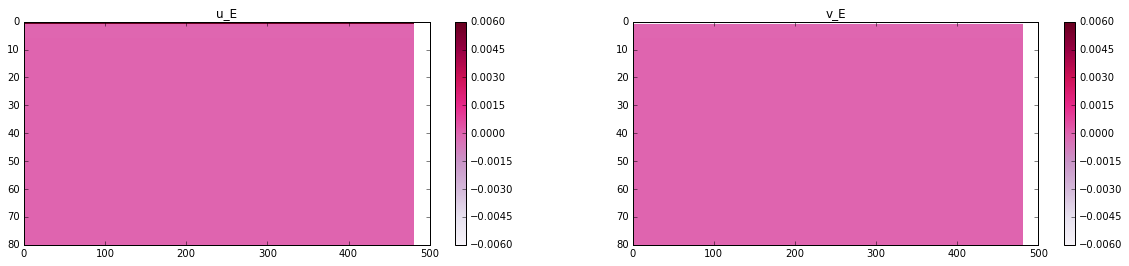

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))
for ax, vel_E, ttl in zip([ax1, ax2], [u_E, v_E], ['u_E','v_E']):
    p = ax.pcolor(vel_E, vmin=-0.006, vmax=0.006, cmap=cm.PuRd)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)

# Pressure driven component

References:
* http://www.rsmas.miami.edu/users/lbeal/MPO603/Lecture%2012.xhtml
* https://ocw.mit.edu/courses/mechanical-engineering/2-011-introduction-to-ocean-science-and-engineering-spring-2006/readings/geostrophic.pdf
* https://marine.rutgers.edu/dmcs/ms501/2004/Notes/Wilkin20041101.htm
* http://talleylab.ucsd.edu/ltalley/sio210/dynamics_rotation/lecture_dynamics_geostrophy.pdf
* http://onlinelibrary.wiley.com/doi/10.1002/2015JC011579/full

Ekman transport resulting from winds distorts the sea surface height. These distortions (hills and valleys) produce geostrophic currents which dominate the large scale circulation patterns in the upper ocean (Beaufort Gyre). Increased pressure caused by the piling up of surface water causes water to flow away.



$$ v_g = \frac{1}{\rho f} \frac{\partial p}{\partial x} $$

$$ u_g = - \frac{1}{\rho f} \frac{\partial p}{\partial y} $$

And:
$$ p = \int_{-z}^{\eta} g \rho(z) dz = \int_{0}^{\eta} g \rho(z) dz + \int_{-z}^{0} g \rho(z) dz$$

So the geostrophic currents are:
$$u_g = - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{-z}^{0} g \rho(z) dz - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_g = \underbrace{\frac{1}{\rho f}\frac{\partial}{\partial x} \int_{-z}^{0} g \rho(z) dz}_\text{V baroclinic} + \underbrace{\frac{g}{f} \frac{\partial \eta}{\partial x}}_\text{V barotropic}$$


# Barotropic rossby radii
$a_s$: barotropic rossby radius over the shelf

$h_S$: depth for y<S

$$a_s = \frac{\sqrt{gh_s}}{f}$$

$a_d$: barotropic rossby radius off the shelf

$h_d$: depth for y>S

$$a_d = \frac{\sqrt{gh_d}}{f}$$

And:
$$\alpha^2 = \frac{H_S}{H_D}$$

In [20]:
def calculate_depth_ratios(fN):
    h_s = 80; h_d = 1300
    a_s = np.sqrt(9.81 * h_s) / np.mean(fN)
    a_d = np.sqrt(9.81 * h_d) / np.mean(fN)
    alpha = np.sqrt(h_s / h_d)
    return a_s, a_d, alpha

In [21]:
a_s, a_d, alpha = calculate_depth_ratios(fN)
type(a_s), type(alpha), a_s.shape, a_d.shape, alpha.shape

(numpy.float64, numpy.float64, (), (), ())

# Allen 1996

$$\eta = - \frac{\int_{t_0}^{t_f} \tau dt}{f^2 a_s} \bigg( \frac{1}{\alpha \sinh (S/a_s) + \cosh(S/a_s)} \bigg) \exp \bigg(\frac{-(y-S)}{a_d} \bigg)$$

Rewritten as:
$$\eta = C \exp \bigg(\frac{-y+S}{a_d} \bigg)$$

where: 

$$ C = - \frac{\int_{t_0}^{t_f} \tau dt}{f a_s \rho} \bigg( \frac{1}{\alpha \sinh (S/a_s) + \cosh(S/a_s)} \bigg)$$

* y=0 at the coast and increases offshore
* S: distance to the shelf break

In [22]:
def calculate_coeff_eta(indt, fN, utau, a_s, dt_s = 3600):
    tau_integral = np.trapz(utau[:indt+1], None, dt_s) 
    coeff_eta = (-1 * tau_integral) / (np.mean(fN) * a_s * 1025)
    return coeff_eta

In [23]:
coeff_eta = calculate_coeff_eta(indt, fN, utau, a_s)
coeff_eta
# 0.059449296347430965

0.059449296347430965

In [24]:
def calculate_trig_brackets(bathy_file, a_s, alpha):
    x_wall = bathy_file['X'][0,:][-1]
    y_wall = bathy_file['Y'][:,0][-1]

    x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
    y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
    z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)
    
    S_y = y_wall - y_break
    arg = S_y / a_s
    brackets_eta = 1 / ((alpha * np.sinh(arg)) + np.cosh(arg))

    return x_wall, y_wall, S_y, brackets_eta 

In [25]:
x_wall, y_wall, S_y, brackets_eta  = calculate_trig_brackets(bathy_file, a_s, alpha)
x_wall, y_wall, S_y, brackets_eta.shape
# (546064.86328401405, 405234.2962823509, 146259.7140481, ())

(518359.27702628367, 386004.3123189169, 146259.7140481, ())

In [26]:
def calculate_eta_alone(coeff_eta, brackets_eta, y_wall, S_y, a_d):
    C = coeff_eta * brackets_eta
    exp_eta = np.exp(((-1 * y_wall) + S_y) / a_d)
    eta = C * exp_eta
    return eta

In [27]:
eta = calculate_eta_alone(coeff_eta, brackets_eta, y_wall, S_y, a_d)
eta
# 0.029659668093547694

0.030154789420446745

# Geostrophic currents

$$\frac{\partial \eta}{\partial y} = - \frac{C}{a_d} \exp \bigg(\frac{-y+S}{a_d} \bigg)$$

for:
$$u_g = - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

and:
$$v_g = +\frac{g}{f} \frac{\partial \eta}{\partial x} = 0$$

In [28]:
def component_geostrophic(coeff_eta, brackets_eta, y_wall, S_y, a_d, fN, u_E):
    C = coeff_eta * brackets_eta
    exp_eta = np.exp(((-1 * y_wall) + S_y) / a_d)
    d_eta_dy = (-1 * C / a_d) * exp_eta
    
    u_g = (-1 * 9.81 / np.mean(fN)) * d_eta_dy
    u_g_bc = np.ones_like(u_E) * u_g
    v_g_bc = np.zeros_like(u_E)
    return C, exp_eta, d_eta_dy, u_g_bc, v_g_bc

In [29]:
C, exp_eta, d_eta_dy, u_g_bc, v_g_bc = component_geostrophic(coeff_eta, brackets_eta, y_wall, S_y, a_d, fN, u_E)
C.shape, exp_eta.shape, d_eta_dy.shape, u_g_bc.shape, v_g_bc.shape

((), (), (), (80, 480), (80, 480))

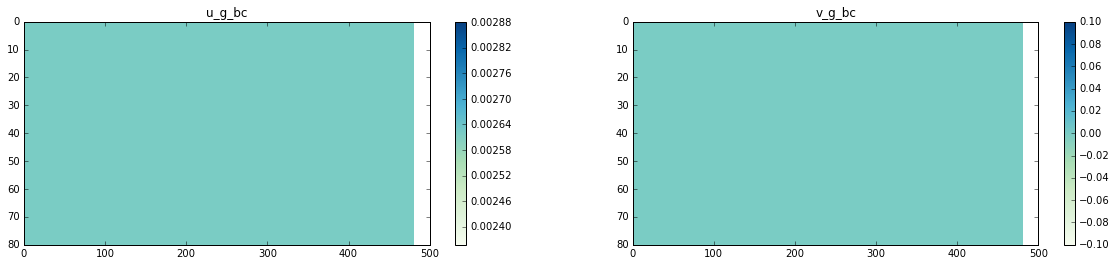

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))
for ax, vel_g, ttl in zip([ax1, ax2], [u_g_bc, v_g_bc], ['u_g_bc','v_g_bc']):
    p = ax.pcolor(vel_g, cmap=cm.GnBu)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)

# Total velocities

$$u = u_g + u_E$$
$$v = v_g + v_E$$

In [31]:
def total_velocity(u_g_bc, v_g_bc, u_E, v_E):
    u_tot = u_g_bc + u_E
    v_tot = v_g_bc + v_E
    return u_tot, v_tot

In [32]:
u_tot, v_tot = total_velocity(u_g_bc, v_g_bc, u_E, v_E)

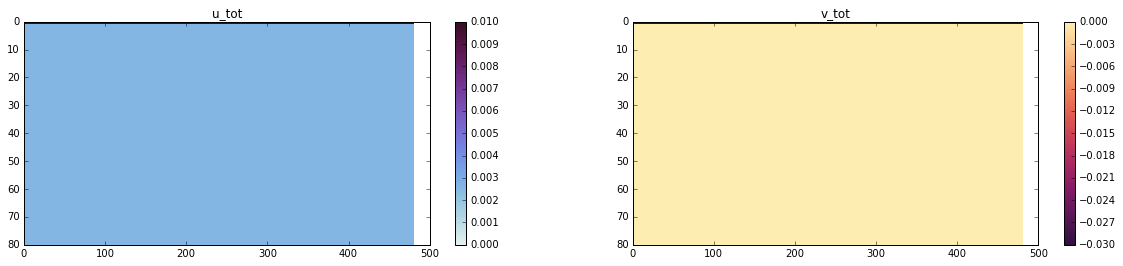

In [33]:
vel_tots = [u_tot, v_tot]
ttls = ['u_tot','v_tot']
cmaps = [cmo.cm.dense, cmo.cm.matter_r]
vmins = [0, -0.03]
vmaxs = [0.01, 0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))
for ax, vel_tot, ttl, cmap, vmin, vmax in zip([ax1, ax2], vel_tots, ttls, cmaps, vmins, vmaxs):
    p = ax.pcolor(vel_tot, cmap=cmap, vmin = vmin, vmax = vmax)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)

# Run all times

In [34]:
indts = np.arange(vtau.shape[0])
indts.shape

(480,)

In [35]:
u_tot_all = np.zeros([indts.shape[0], sal.shape[0], sal.shape[-1]])
v_tot_all = np.zeros_like(u_tot_all)
eta_all = np.zeros([indts.shape[0], sal.shape[-1]])

v_tot.shape, v_tot_all.shape
# ((80, 237), (480, 80, 237))

((80, 480), (480, 80, 480))

In [36]:
latN, f = calculate_coriolis(nav_lat) #1
deps, lats, p = calculate_pressure(deptht, latN) #3
SA, CT, rho = calculate_rho(sal, tem, p) #4

for indt in (indts):
    vEN, fN, delta = calculate_ekman_thickness(indt, vE, f) #2
    coeff, brackets, tao_x, tao_y, u_E, v_E = component_ekman(indt, rho, fN, delta, deps, utau, vtau) #5
    a_s, a_d, alpha = calculate_depth_ratios(fN) #6
    coeff_eta = calculate_coeff_eta(indt, fN, utau, a_s) #7
    x_wall, y_wall, S_y, brackets_eta  = calculate_trig_brackets(bathy_file, a_s, alpha) #8
    eta = calculate_eta_alone(coeff_eta, brackets_eta, y_wall, S_y, a_d) #9
    C, exp_eta, d_eta_dy, u_g_bc, v_g_bc = component_geostrophic(coeff_eta, brackets_eta, y_wall, S_y, a_d, fN, u_E)#10
    u_tot, v_tot = total_velocity(u_g_bc, v_g_bc, u_E, v_E) #11
    
    u_tot_all[indt, :, :] = u_tot
    v_tot_all[indt, :, :] = v_tot
    eta_all[indt, :] = eta

In [37]:
eta, eta_all.shape
# (0.21190774201604567, (480, 237))

(0.21544520717163149, (480, 480))

In [41]:
def plot_fig(ax, time_inds, vel_tot_all, cmap, vmin, vmax):
    for t, n in zip(time_inds, np.arange(len(time_inds))):
        p = ax[n].pcolor(vel_tot_all[t,:,:], cmap=cmap, vmin = vmin, vmax = vmax)
        ax[n].set_title(str(t) + ' (tau ' + str(np.round(utau[t],2))+ ')',fontsize=15)
        ax[n].set_ylim([vel_tot_all.shape[1],0])
        ax[n].set_xlim([0,vel_tot_all.shape[2]])
        if n == 9:
            fig.colorbar(p, ax=ax[9])
    return ax

# Total U velocity

In [39]:
u_tot_all.min(), u_tot_all.max()
# (-2.148936547716021e-07, 0.019441041572387616)
# (-8.3244113284793378e-11, 0.026619033575428448)

(-1.6298389228077952e-10, 0.025782367943558815)

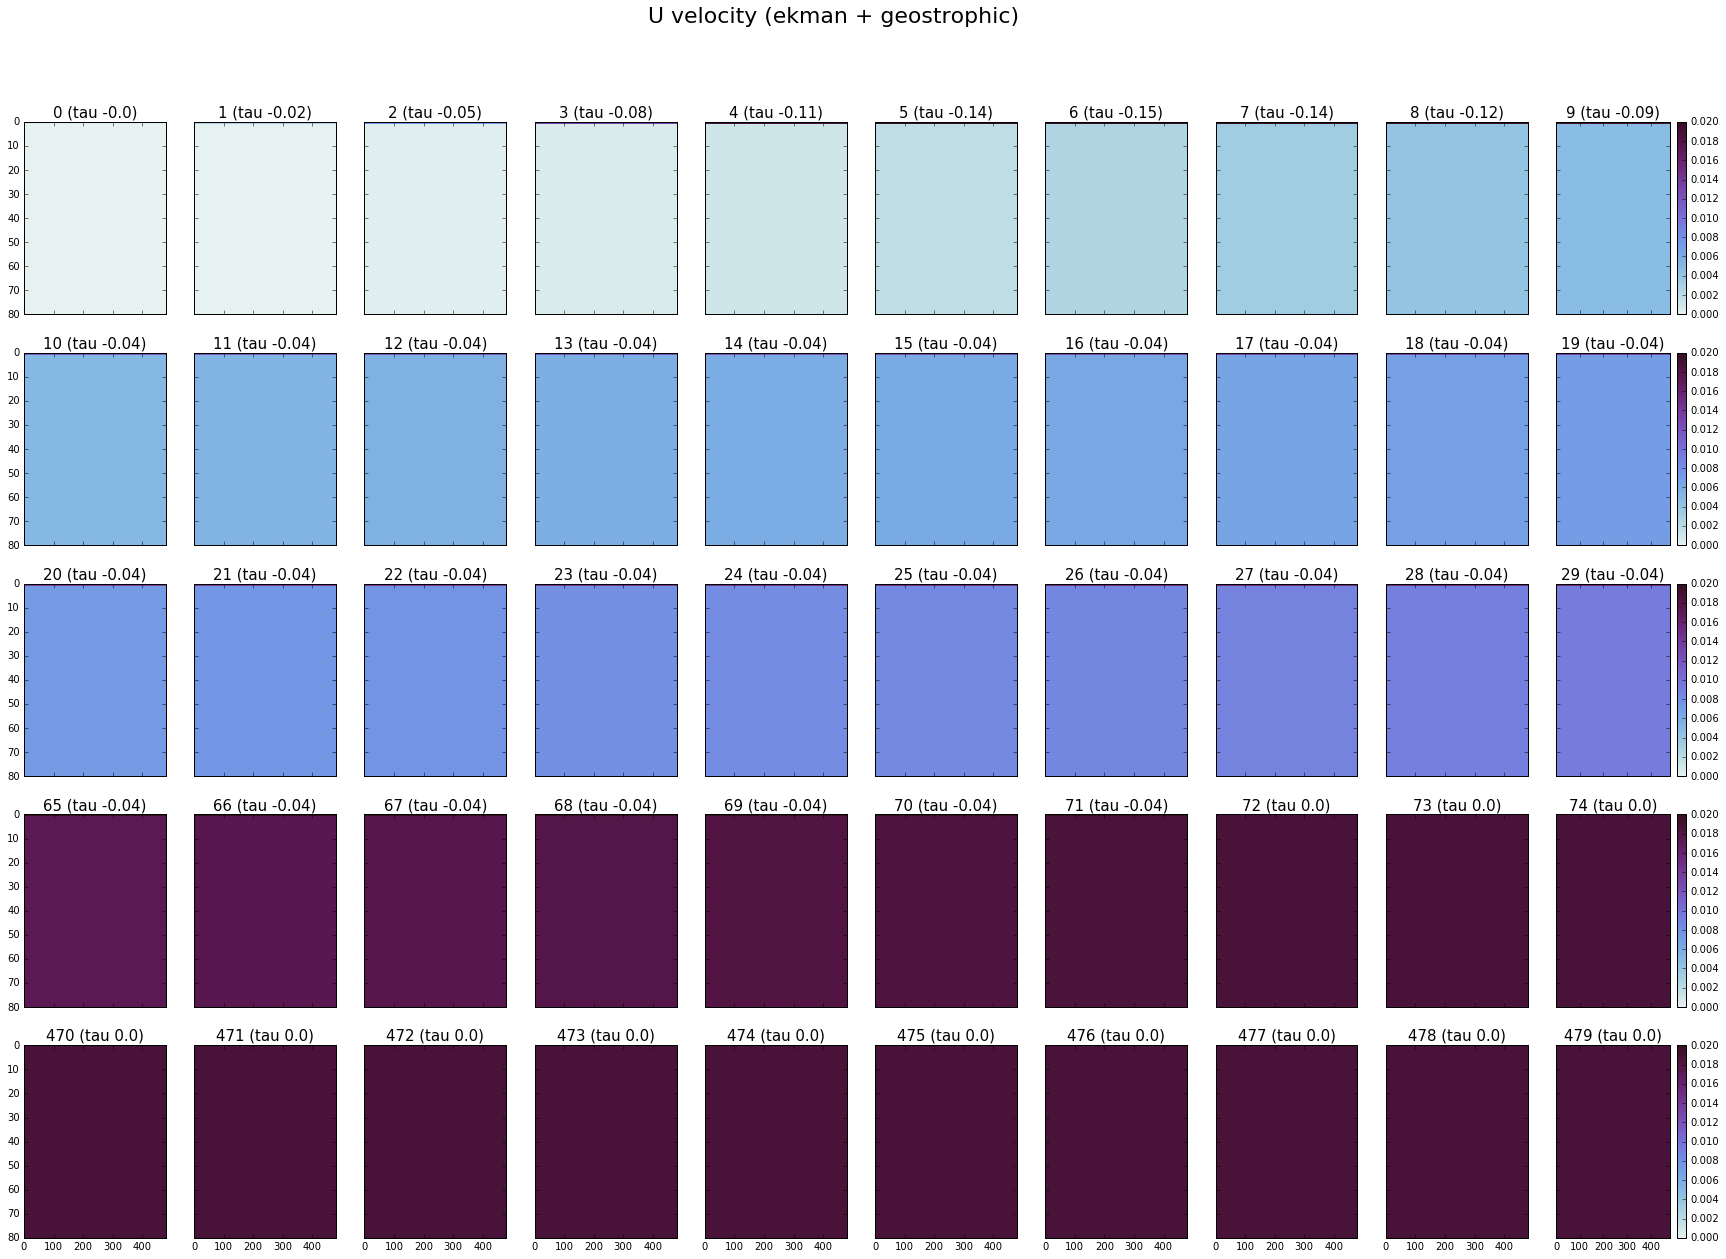

In [42]:
vmin, vmax = 0, 0.02
fig, (axA, axB, axC, axD, axE) = plt.subplots(5,10, figsize=(30,20), sharex=True, sharey=True)
ax = plot_fig(axA, np.arange(10), u_tot_all, cmo.cm.dense, vmin, vmax)
ax = plot_fig(axB, np.arange(10,20), u_tot_all, cmo.cm.dense, vmin, vmax)
ax = plot_fig(axC, np.arange(20,30), u_tot_all, cmo.cm.dense, vmin, vmax)
ax = plot_fig(axD, np.arange(65,75), u_tot_all, cmo.cm.dense, vmin, vmax)
ax = plot_fig(axE, np.arange(470,480), u_tot_all, cmo.cm.dense, vmin, vmax)
fig.suptitle('U velocity (ekman + geostrophic)', fontsize=22)

# Total V velocity

In [43]:
v_tot_all.min(), v_tot_all.max()
# (-0.026073984346320793, 4.3713395465973311e-09)
# (-0.033961632867377918, 5.5982152168656835e-23)

(-0.033683343713453225, 4.3639894641488426e-21)

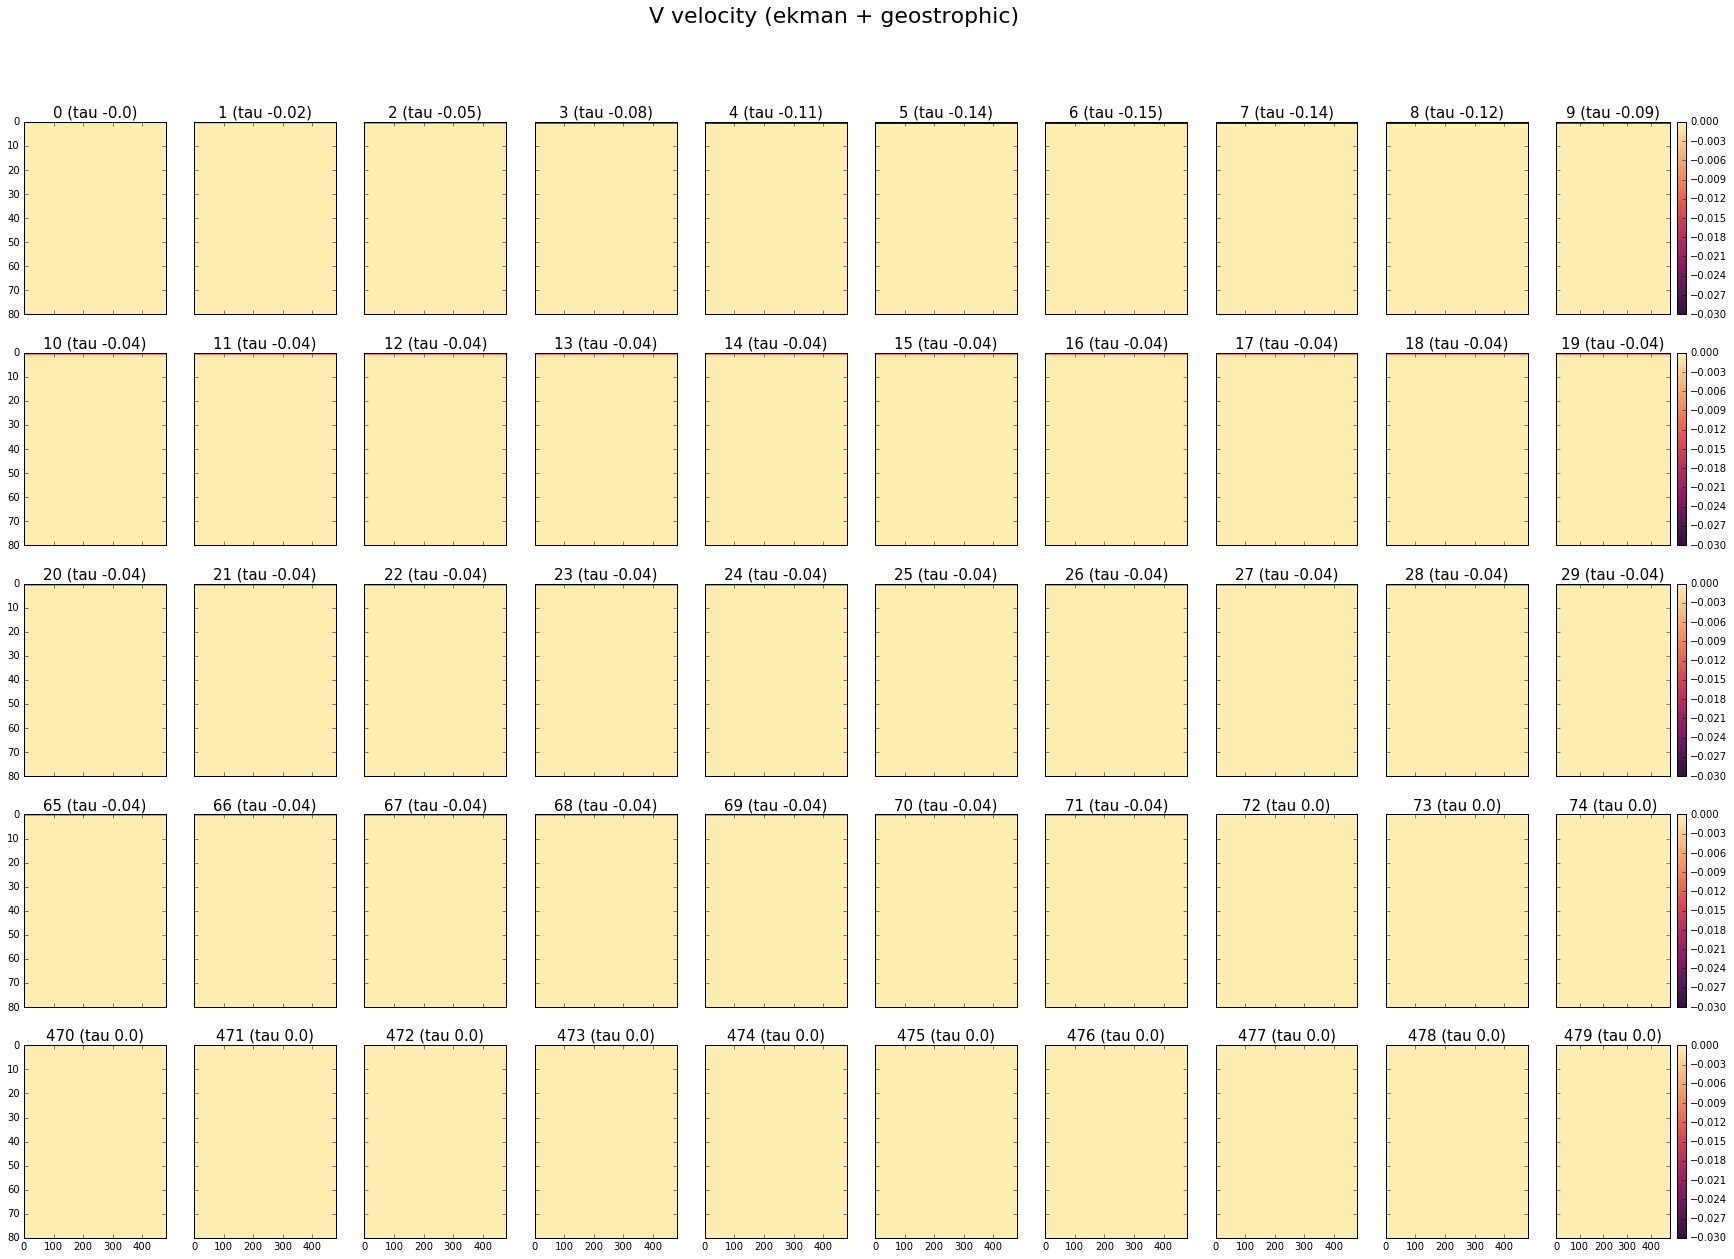

In [44]:
vmin, vmax = -0.03, 0
fig, (axA, axB, axC, axD, axE) = plt.subplots(5,10, figsize=(30,20), sharex=True, sharey=True)
ax = plot_fig(axA, np.arange(10), v_tot_all, cmo.cm.matter_r, vmin, vmax)
ax = plot_fig(axB, np.arange(10,20), v_tot_all, cmo.cm.matter_r, vmin, vmax)
ax = plot_fig(axC, np.arange(20,30), v_tot_all, cmo.cm.matter_r, vmin, vmax)
ax = plot_fig(axD, np.arange(65,75), v_tot_all, cmo.cm.matter_r, vmin, vmax)
ax = plot_fig(axE, np.arange(470,480), v_tot_all, cmo.cm.matter_r, vmin, vmax)
fig.suptitle('V velocity (ekman + geostrophic)', fontsize=22)

# Splitting barotropic and baroclinic
Manual p. 171: The boundary condition should be set for the barotropic solution (u2d: sea surface height and barotropic velocities) and for the baroclinic velocities (u3d). The nambdy_dta namelist must be set for external boundary data (one namelist for each boundary). The data is read using the fldread module.

In [45]:
u2d = np.mean(u_tot_all, axis=1)
v2d = np.mean(v_tot_all, axis=1)

u3d = np.zeros_like(u_tot_all)
v3d = np.zeros_like(v_tot_all)

for i in np.arange(u3d.shape[1]):
    u3d[:,i,:] = u_tot_all[:,i,:] - u2d
    v3d[:,i,:] = v_tot_all[:,i,:] - v2d

u2d.shape, u3d.shape
# ((480, 237), (480, 80, 237))

((480, 480), (480, 80, 480))

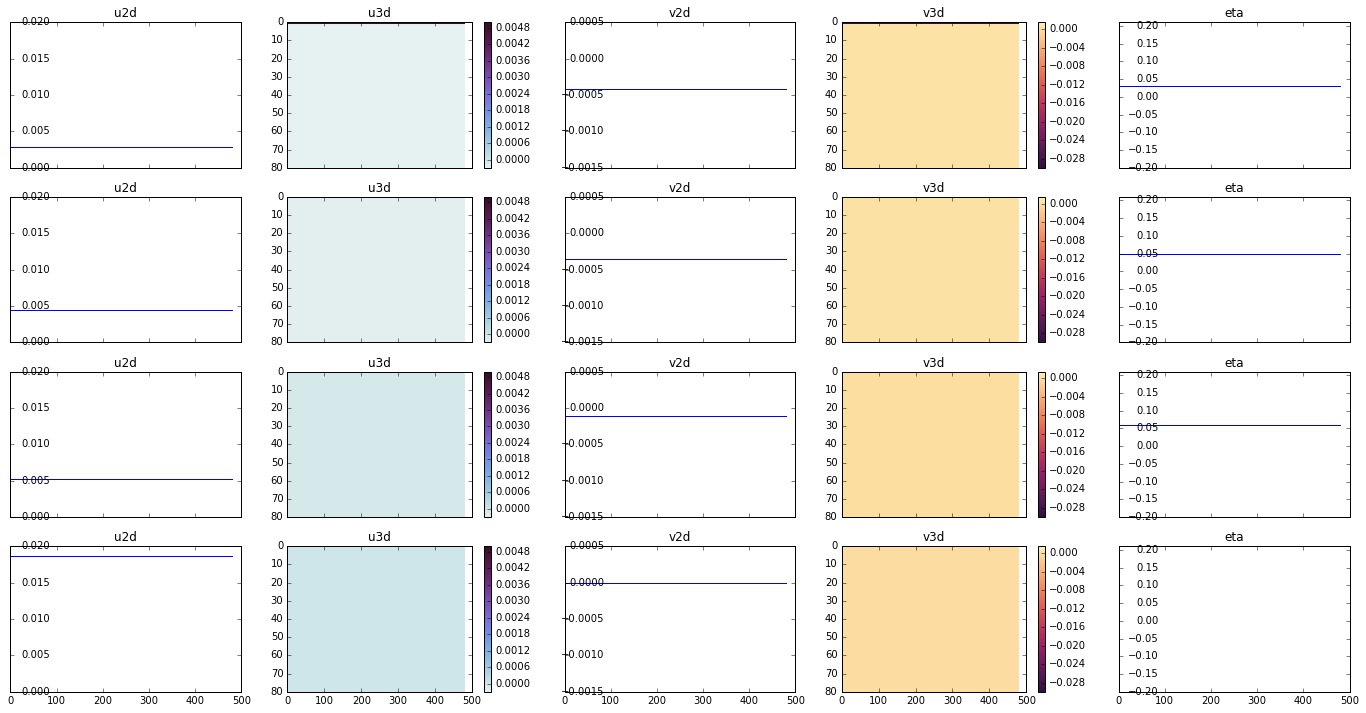

In [46]:
fig, (axA, axB, axC, axD) = plt.subplots(4,5, figsize=(24, 12), sharex=True)
time_inds = [6, 8, 10, 72]
var_all = [u2d, u3d, v2d, v3d, eta_all]
cmaps = [cmo.cm.dense, cmo.cm.dense, cmo.cm.matter_r, cmo.cm.matter_r, cmo.cm.algae]
vmins = [0   , -0.0003, -0.0015, -0.03 , -0.2]
vmaxs = [0.02, 0.005  , 0.0005 , 0.0015, 0.21]
ttls = ['u2d', 'u3d', 'v2d', 'v3d', 'eta']

for t, ax in zip(time_inds, [axA, axB, axC, axD]):
    for n, var, cmap, vmin, vmax, ttl in zip(np.arange(5), var_all, cmaps, vmins, vmaxs, ttls):
        ax[n].set_title(ttl)
        if ttl == 'u3d' or ttl == 'v3d':
            p = ax[n].pcolor(var[t,:,:], cmap=cmap, vmin = vmin, vmax = vmax)
            fig.colorbar(p, ax = ax[n])
            ax[n].set_ylim([var.shape[1],0])
        else:
            ax[n].plot(var[t,:])
            ax[n].set_ylim([vmin,vmax])
            ax[n].tick_params(axis='y', which='major', pad=-40)

# Making a file

bn_ssh = sossheig, bn_u2d = vobtcrtx, bn_v2d = vobtcrty, bn_u3d = vozocrtx, bn_v3d = vomecrty

In [47]:
eta_all.shape, u2d.shape, v2d.shape, u3d.shape, v3d.shape
#((480, 237), (480, 237), (480, 237), (480, 80, 237), (480, 80, 237))

((480, 480), (480, 480), (480, 480), (480, 80, 480), (480, 80, 480))

In [48]:
hours_month = 24*31
fill_month = hours_month - u3d.shape[0]
fillt = np.zeros([fill_month, u2d.shape[1]])
fillc = np.zeros([fill_month, u3d.shape[1], u3d.shape[2]])

eta_file = np.append(eta_all, fillt, axis=0)
u2d_file = np.append(u2d, fillt, axis=0)
v2d_file = np.append(v2d, fillt, axis=0)
u3d_file = np.append(u3d, fillc, axis=0)
v3d_file = np.append(v3d, fillc, axis=0)

eta_file.shape, u2d_file.shape, v2d_file.shape, u3d_file.shape, v3d_file.shape
# ((744, 237), (744, 237), (744, 237), (744, 80, 237), (744, 80, 237))

((744, 480), (744, 480), (744, 480), (744, 80, 480), (744, 80, 480))

In [49]:
eta_file.max()

0.21544520717163149